In [65]:
import sys
import os

# Get the current directory of the notebook
notebook_dir = os.path.abspath('')
_dir = os.path.dirname(notebook_dir)
_dir = os.path.dirname(_dir)
_dir = os.path.dirname(_dir)
sys.path.append(_dir)

<hr />

In [66]:
from util.structs import DataCluster, Dataset, Measurement
from util import mymath, csv_table, graph
import numpy as np

In [67]:
U_e = Measurement(.384, "1%")

table = csv_table.read("./data/234d")
header = table[0]
print(header)
table_data = table[1:]
data = DataCluster()

indicies = {
    "phi": r"$\varphi$ [deg]",
}


for row in table_data:
    dset = Dataset({
        "R": float(row[0]),
        # "R": Measurement(float(row[0]), "1%"),
        "U_R": float(row[1]) * 1e-3,
        "U_C": float(row[2]) * 1e-3,
        indicies["phi"]: float(row[3]) / 34 * 360
    })
    data.add(dset)

print(data)
data.save.to_excel("./output/input_table_234d")

['R' ' U_R' ' U_C' ' phi[360/34]']
$\varphi$ [deg]    | R      | U_C                 | U_R  
-------------------+--------+---------------------+------
180.0              | 0.0    | 0.384               | 0.0  
148.23529411764704 | 25.0   | 0.34600000000000003 | 0.136
116.47058823529413 | 30.0   | 0.325               | 0.18 
95.29411764705883  | 50.0   | 0.28800000000000003 | 0.225
63.529411764705884 | 100.0  | 0.2                 | 0.308
31.764705882352942 | 200.0  | 0.115               | 0.354
21.176470588235293 | 400.0  | 0.06                | 0.373
10.588235294117647 | 800.0  | 0.029               | 0.38 
5.294117647058823  | 1000.0 | 0.024               | 0.38 
0.0                | inf    | 0.0                 | 0.384



In [68]:
import math

def calc_tip_point(leftlenght, rightlenght, hypotenuse):
    if not math.isclose(hypotenuse**2, leftlenght**2 + rightlenght**2):
        print("Not good triangle!", leftlenght, rightlenght, hypotenuse)
    # else:
    #     print("Good triangle!", leftlenght, rightlenght, hypotenuse)

    x = leftlenght**2 / hypotenuse
    # equivalent
    # x_2 = hypotenuse - rightlenght**2 / hypotenuse
    y = leftlenght * rightlenght / hypotenuse
    return x, y

for d in data:
    max_lenght = (d["U_R"]**2 + d["U_C"]**2)**0.5
    x, y = calc_tip_point(d["U_R"], d["U_C"], max_lenght)
    d["x2"] = x
    d["y2"] = y

In [69]:
def circle_intersection(r1, r2, x1 = 0, y1 = 0, x2 = 0, y2 = 0):
    # Calculate the distance between the centers
    dx = x2 - x1
    dy = y2 - y1
    d = math.sqrt(dx**2 + dy**2)
    
    # Check if there are no intersections
    if d > r1 + r2 or d < abs(r1 - r2) or (d == 0 and r1 == r2):
        print("No intersection", r1, r2)
        return None  # No intersection
    
    # Calculate the x-coordinate of the midpoint of the intersection line
    a = (r1**2 - r2**2 + d**2) / (2 * d)
    h = math.sqrt(r1**2 - a**2)
    
    # Midpoint between the centers along the line connecting them
    x_mid = x1 + a * dx / d
    y_mid = y1 + a * dy / d
    
    # Offset for the intersection points
    offset_x = -h * dy / d
    offset_y = h * dx / d
    
    # Intersection points
    intersection1 = (x_mid + offset_x, y_mid + offset_y)
    intersection2 = (x_mid - offset_x, y_mid - offset_y)
    
    return intersection1, intersection2

for d in data:
    try:
       one, two = circle_intersection(d["U_R"], d["U_C"], x2 = U_e.value);
    except:
        pass
    d["x"] = one[0]
    d["y"] = one[1]

print(data)

$\varphi$ [deg]    | R      | U_C                 | U_R   | x                   | x2                   | y                    | y2                  
-------------------+--------+---------------------+-------+---------------------+----------------------+----------------------+---------------------
180.0              | 0.0    | 0.384               | 0.0   | 0.0                 | 0.0                  | 0.0                  | 0.0                 
148.23529411764704 | 25.0   | 0.34600000000000003 | 0.136 | 0.06020312499999998 | 0.049751358156441904 | 0.12194910307269333  | 0.12657330825094779 
116.47058823529413 | 30.0   | 0.325               | 0.18  | 0.09665494791666665 | 0.08720996903743836  | 0.15184801955648436  | 0.1574624440953748  
95.29411764705883  | 50.0   | 0.28800000000000003 | 0.225 | 0.14991796875       | 0.1385199094437709   | 0.16777843319650482  | 0.17730548408802677 
63.529411764705884 | 100.0  | 0.2                 | 0.308 | 0.2634375           | 0.25831725365413255  | 0

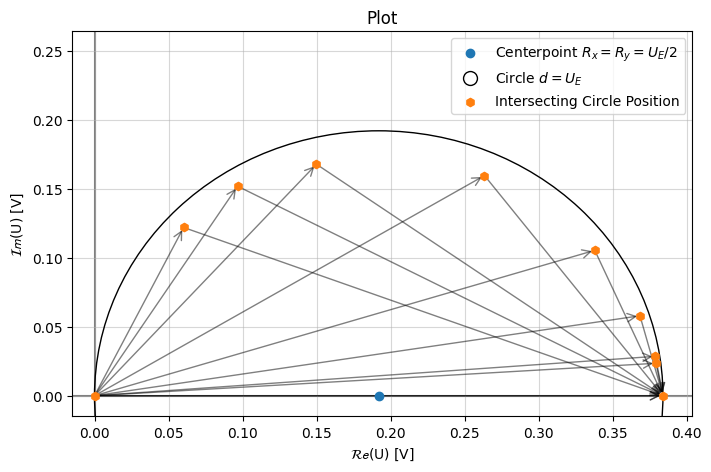

In [73]:
from matplotlib.patches import FancyArrowPatch, Circle
from matplotlib.lines import Line2D

plot = graph.create_plot(figsize=(8, 5))
fig, ax = plot

ax.set_xlabel(r"$\mathcal{Re}$(U) [V]")
ax.set_ylabel(r"$\mathcal{Im}$(U) [V]")
ax.set_title("Plot")

def render_circ(r=1, x=0, y=0, **kwargs):
    circle = Circle((x,y), r, edgecolor='black', facecolor='none', **kwargs)
    ax.add_patch(circle)

def render_dset(d):
    render_circ(d["U_R"], 0, 0)
    render_circ(d["U_C"], U_e.value, 0)

def render_arrow(d):
    start = (0, 0)
    mid = (d["x"], d["y"])
    end = (U_e.value, 0)
    arrow_params = {
        'mutation_scale': 15,
        'color': 'black',
        # 'color': 'orange',
        'arrowstyle': '->',
        "alpha": 0.5,
    }
    arrow1 = FancyArrowPatch(start, mid, **arrow_params);
    arrow2 = FancyArrowPatch(mid, end, **arrow_params);
    ax.add_patch(arrow1)
    ax.add_patch(arrow2)

for d in data:
    render_arrow(d);

radius = (U_e/2).value
ax.scatter(radius, 0, label=r"Centerpoint $R_x = R_y = U_E/2$")
render_circ(radius, radius, 0, label=r"Circle $d = U_E$");

# graph.scatter_data(data, "x", "y", False, plot=plot, s=10, zorder=2, label="triangle tips")
graph.scatter_data(data, "x", "y", False, plot=plot, zorder=2, label="Intersecting Circle Position", marker="h")
# graph.scatter_data(data, "x2", "y2", False, plot=plot, zorder=2, label="assuming 90°", marker="h")

ax.axhline(0, color="black", alpha=.5, zorder=0)
ax.axvline(0, color="black", alpha=.5, zorder=0)

ax.set_axisbelow(True)
ax.grid(True, zorder=0, alpha=.5)

# ax.set_ylim(0,)
ymax = ax.get_ylim()[1]
ax.set_ylim(-.015, 1.25*ymax)
# ax.set_xlim(0,)
ax.set_xlim(-.015,)

circle_proxy = Line2D([0], [0], marker='o', color='none', markeredgecolor='black', markerfacecolor='none', markersize=10, label="Circle")
handles, labels = ax.get_legend_handles_labels()
handles[1] = circle_proxy

# ax.set_aspect(1/1)
ax.legend(handles=handles, labels=labels)

fig.savefig("./output/plot_234d.pdf", dpi=500);

In [71]:
print(data)

$\varphi$ [deg]    | R      | U_C                 | U_R   | x                   | x2                   | y                    | y2                  
-------------------+--------+---------------------+-------+---------------------+----------------------+----------------------+---------------------
180.0              | 0.0    | 0.384               | 0.0   | 0.0                 | 0.0                  | 0.0                  | 0.0                 
148.23529411764704 | 25.0   | 0.34600000000000003 | 0.136 | 0.06020312499999998 | 0.049751358156441904 | 0.12194910307269333  | 0.12657330825094779 
116.47058823529413 | 30.0   | 0.325               | 0.18  | 0.09665494791666665 | 0.08720996903743836  | 0.15184801955648436  | 0.1574624440953748  
95.29411764705883  | 50.0   | 0.28800000000000003 | 0.225 | 0.14991796875       | 0.1385199094437709   | 0.16777843319650482  | 0.17730548408802677 
63.529411764705884 | 100.0  | 0.2                 | 0.308 | 0.2634375           | 0.25831725365413255  | 0

In [72]:
data = data.copy_remove_index("x2")
data = data.copy_remove_index("y2")
data.save.to_excel("./output/table_234d")
print(data)

$\varphi$ [deg]    | R      | U_C                 | U_R   | x                   | y                   
-------------------+--------+---------------------+-------+---------------------+---------------------
180.0              | 0.0    | 0.384               | 0.0   | 0.0                 | 0.0                 
148.23529411764704 | 25.0   | 0.34600000000000003 | 0.136 | 0.06020312499999998 | 0.12194910307269333 
116.47058823529413 | 30.0   | 0.325               | 0.18  | 0.09665494791666665 | 0.15184801955648436 
95.29411764705883  | 50.0   | 0.28800000000000003 | 0.225 | 0.14991796875       | 0.16777843319650482 
63.529411764705884 | 100.0  | 0.2                 | 0.308 | 0.2634375           | 0.15957657595571478 
31.764705882352942 | 200.0  | 0.115               | 0.354 | 0.33795182291666664 | 0.10537820167046873 
21.176470588235293 | 400.0  | 0.06                | 0.373 | 0.3684700520833334  | 0.057955333815841094
10.588235294117647 | 800.0  | 0.029               | 0.38  | 0.37892578125